In [1]:
import numpy as np
import matplotlib.pyplot as plt

class stepSignal():
    def __init__(self, amp, shift):
        self.amp = amp
        self.shift = shift
    def sample(self, Fs, period):
        sampleAmount = int(Fs * period)
        shiftStep = int(Fs * self.shift)
        
        indices = np.arange(0, sampleAmount, 1)
        mask = (indices >= shiftStep)
        return np.where(mask, self.amp, 0)

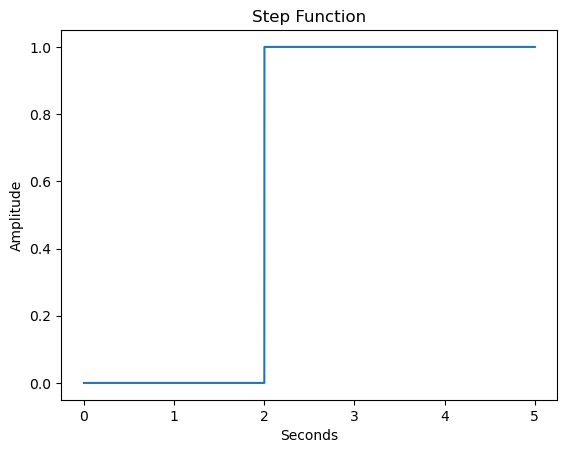

In [2]:
Fs = 50000
period = 5

signal = stepSignal(amp = 1, shift = 2)
sample = signal.sample(Fs = Fs, period = period)

xAxis = np.arange(0, period, 1/Fs)
yAxis = sample

plt.plot(xAxis, yAxis)
plt.xlabel("Seconds")
plt.ylabel("Amplitude")
plt.title("Step Function")
plt.show()

[0.00000e+00 2.00000e-01 4.00000e-01 ... 2.49996e+04 2.49998e+04
 2.50000e+04]


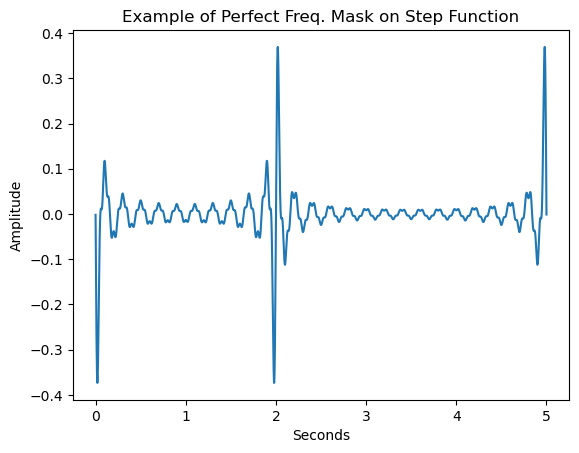

In [3]:
sampleFFT = np.fft.rfft(sample)
freqs = np.fft.rfftfreq(len(sample), d = 1/Fs)
print(freqs)

f_low = 5
f_high = 20

mask = np.where((freqs >= f_low) & (freqs <= f_high), 1, 0)
sampleFFT = sampleFFT * mask

sampleFiltered = np.fft.irfft(sampleFFT)
xAxis = np.arange(0, period, 1/Fs)
yAxis = sampleFiltered
plt.plot(xAxis, yAxis)
plt.title("Example of Perfect Freq. Mask on Step Function")
plt.xlabel("Seconds")
plt.ylabel("Amplitude")
plt.show()

In [4]:
class CosineWaveform:
    def __init__(self, freq, amp, phase):
        self.freq = freq
        self.amp = amp
        self.phase = phase
    def sample(self, Fs, period, timeErrorLevel = 0):
        #Added a time error level to simulate imperfect clock
        sampleTime = 1 / Fs
        timeSTD = timeErrorLevel * sampleTime
        timeErrorArray = np.array([np.random.normal(loc = 0, scale = timeSTD**2)])
        
        timeArray = np.arange(0, period, 1/Fs)
        return self.amp * np.cos(2 * np.pi * self.freq * (timeArray + timeErrorArray) + self.phase)
    
class Noise:
    def __init__(self, mean, sigma):
        self.mean = mean
        self.sigma = sigma
    def sample(self, Fs, period, timeErrorLevel = 0):
        timeArray = np.arange(0, period, 1/Fs)
        return np.array([np.random.normal(loc = self.mean, scale = self.sigma, size = None) for time in timeArray])
    
class Signal:
    def __init__(self, components):
        self.components = components
        
    def sample(self, Fs, period, timeErrorLevel = 0, quantize = False, UPPER_LIMIT = 1, LOWER_LIMIT = -1):
        waveformArray = np.array([waveform.sample(Fs, period, timeErrorLevel) for waveform in self.components])
        temp = np.zeros(waveformArray.shape[1])
        
        for waveform in waveformArray:
            temp += waveform
        if quantize:
            temp = self.Quantize12Bit(temp, Fs, period, UPPER_LIMIT, LOWER_LIMIT)
        return temp
    
    def Quantize12Bit(self, signal, Fs, period, UPPER_LIMIT, LOWER_LIMIT):
        binRange = UPPER_LIMIT - LOWER_LIMIT
        clippedSignal = np.clip(signal, LOWER_LIMIT, UPPER_LIMIT)
        binWidth = binRange / (2**12 - 1)
        quantized = np.round((clippedSignal - LOWER_LIMIT) / binWidth) * binWidth + LOWER_LIMIT
        return quantized
    
    @staticmethod
    def downSample(Fs, period, signal):
        sampleRatio = len(signal) / (Fs * period)
        indexArray = np.arange(0, len(signal), int(sampleRatio))
        return signal[indexArray]
    
def plotSignal(signal, Fs, period, displayPeriod = 0):
    if displayPeriod == 0: displayPeriod = period
    
    xAxis = np.arange(0, period, 1/ Fs)
    plt.plot(xAxis, signal)
    plt.axis([0, displayPeriod, np.min(signal), np.max(signal)])
    plt.show()

In [8]:
waveform = Signal(np.array([
    CosineWaveform(freq = 200, amp = 1, phase = 0),
    CosineWaveform(freq = 400, amp = 1, phase = 0),
    Noise(mean = 0, sigma = 5)
]))

Fs = 50000
period  = 5

sample = waveform.sample(Fs = Fs, period = period, timeErrorLevel = 1 * (10**-2), 
                         quantize = True, UPPER_LIMIT = 2, LOWER_LIMIT = -2)

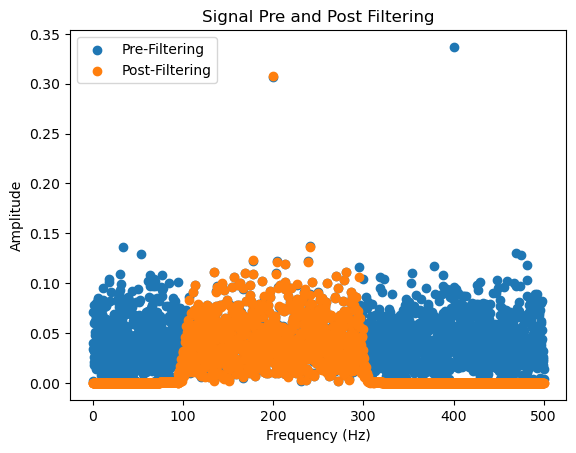

In [9]:
Fs = 1000
period = 5

downSample = Signal.downSample(Fs, period, signal = sample)

sampleFFT = np.fft.rfft(downSample)
freqs = np.fft.rfftfreq(len(downSample), 1 / Fs)
yAxis = abs(sampleFFT) / len(downSample)
yAxis[1:-1] *= 2

plt.scatter(freqs, yAxis, label = "Pre-Filtering")
plt.title("Signal Pre-Filtering")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")

N = 201
f_low = 100
f_high = 300
w_low = 2 * np.pi * f_low / Fs #divide Fs as omega is discrete-time angular frequency
w_high = 2 * np.pi * f_high / Fs

n = np.arange(N) - (N-1)/2.0
h = (w_high/np.pi) * np.sinc((w_high / np.pi) *n) - (w_low/np.pi) * np.sinc((w_low / np.pi) *n)
hWindow = h * np.hanning(N) #apply the window

convolved = np.convolve(downSample, hWindow, mode = "same") #convolve with orignal signal

fft = np.fft.rfft(convolved)
freqs = np.fft.rfftfreq(len(downSample), 1/Fs)

yAxis = abs(fft) / len(convolved)
yAxis[1:-1] *= 2

plt.scatter(freqs, yAxis, label = "Post-Filtering")
plt.title("Signal Pre and Post Filtering")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.legend()

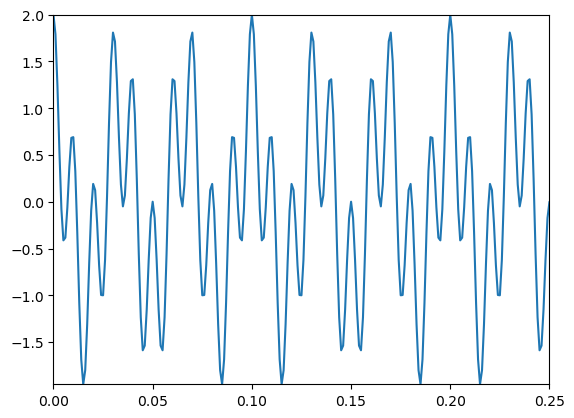

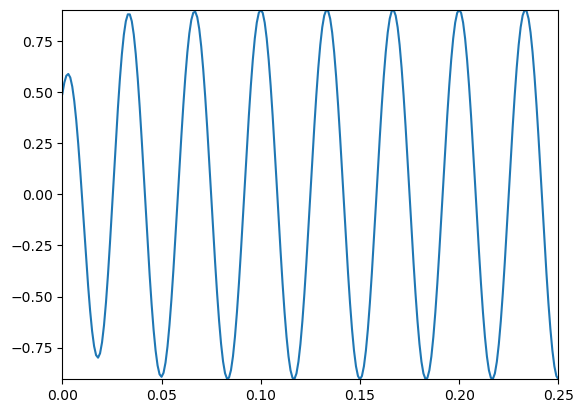

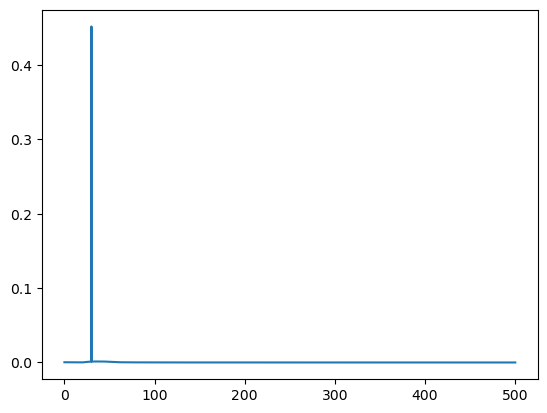

In [15]:
def FIRFilter(sample, f_low, f_high, Fs, N):
    w_low = 2 * np.pi * f_low / Fs
    w_high = 2 * np.pi * f_high / Fs
    
    n = np.arange(N) - (N-1)/2
    h = (w_high/np.pi) * np.sinc((w_high / np.pi) *n) - (w_low/np.pi) * np.sinc((w_low / np.pi) *n)

    hWindow = h * np.hanning(N)
    convolved = np.convolve(sample, hWindow, mode = "same")
    return convolved

waveform = Signal(np.array([
    CosineWaveform(freq = 30, amp = 1, phase = 0),
    CosineWaveform(freq = 100, amp = 1, phase = 0),
]))

Fs = 1000
period = 5

sample = waveform.sample(Fs = Fs, period = period, timeErrorLevel = 0, quantize = True, UPPER_LIMIT = 2, LOWER_LIMIT = -2)

plotSignal(sample, Fs, period, 0.25)

f_low = 25
f_high = 45
taps = 201

filtered = FIRFilter(sample, f_low, f_high, Fs, taps)

plotSignal(filtered, Fs, period, 0.25)

fft = np.fft.rfft(filtered)
freqs = np.fft.rfftfreq(len(filtered), 1/Fs)

fft = abs(fft) / len(filtered)

plt.plot(freqs, fft)

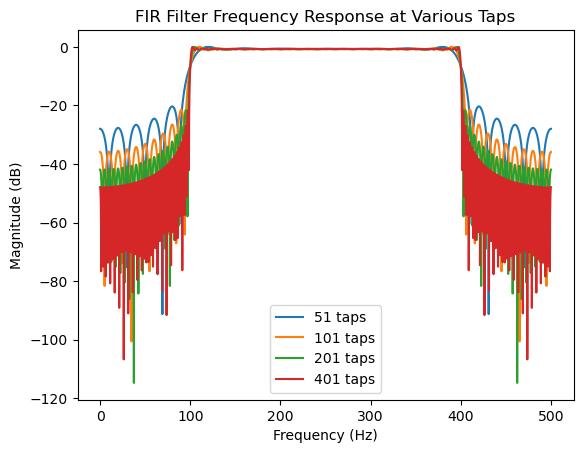

In [41]:
#Im going to now try to plot the frequency response for my FIR filter at diffrent amount of taps and bandwidths

#define a sampling rate for the impulse response signal
Fs = 1000

taps1 = 51
taps2 = 101
taps3 = 201
taps4 = 401

f_low = 100 #hz
f_high = 400

w_low1 = 2 * np.pi * f_low / Fs
w_high1 = 2 * np.pi * f_high / Fs

#creating an array of taps centered
n1 = np.arange(taps1) - (taps1 - 1) / 2
n2 = np.arange(taps2) - (taps2 - 1) / 2
n3 = np.arange(taps3) - (taps3 - 1) / 2
n4 = np.arange(taps4) - (taps4 - 1) / 2

#creating the time domain weighting function/ impuslse respose of the FIR filter at each tap amount
h1 = (w_high1 / np.pi) * np.sinc((w_high1 / np.pi) * n1) - (w_low1 / np.pi) * np.sinc((w_low1 / np.pi) * n1)
h2 = (w_high1/ np.pi) * np.sinc((w_high1 / np.pi) * n2) - (w_low1 / np.pi) * np.sinc((w_low1 / np.pi) * n2)
h3 = (w_high1 / np.pi) * np.sinc((w_high1 / np.pi) * n3) - (w_low1 / np.pi) * np.sinc((w_low1 / np.pi) * n3)
h4 = (w_high1 / np.pi) * np.sinc((w_high1 / np.pi) * n4) - (w_low1 / np.pi) * np.sinc((w_low1 / np.pi) * n4)

#frequency domain
H1 = np.fft.rfft(h1, 8192) #8192 to zero pad the FFT passed the n taps
H2 = np.fft.rfft(h2, 8192)
H3 = np.fft.rfft(h3, 8192)
H4 = np.fft.rfft(h4, 8192)

freqs = np.fft.rfftfreq(8192, 1 / Fs)

#Plotting decibels to express the power at each frequency
H1_mag = np.abs(H1)
H1_mag /= np.max(H1_mag)
H2_mag = np.abs(H2)
H2_mag /= np.max(H2_mag)
H3_mag = np.abs(H3)
H3_mag /= np.max(H3_mag)
H4_mag = np.abs(H4)
H4_mag /= np.max(H4_mag)

decibels1 = 20*np.log10(np.maximum(np.abs(H1_mag), 1e-12)) #if value below 1e-12: clip
decibels2 = 20*np.log10(np.maximum(np.abs(H2_mag), 1e-12))
decibels3 = 20*np.log10(np.maximum(np.abs(H3_mag), 1e-12))
decibels4 = 20*np.log10(np.maximum(np.abs(H4_mag), 1e-12))

plt.plot(freqs, decibels1, label = "51 taps")
plt.plot(freqs, decibels2, label = "101 taps")
plt.plot(freqs, decibels3, label = "201 taps")
plt.plot(freqs, decibels4, label = "401 taps")
plt.title("FIR Filter Frequency Response at Various Taps")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.legend()
plt.show()

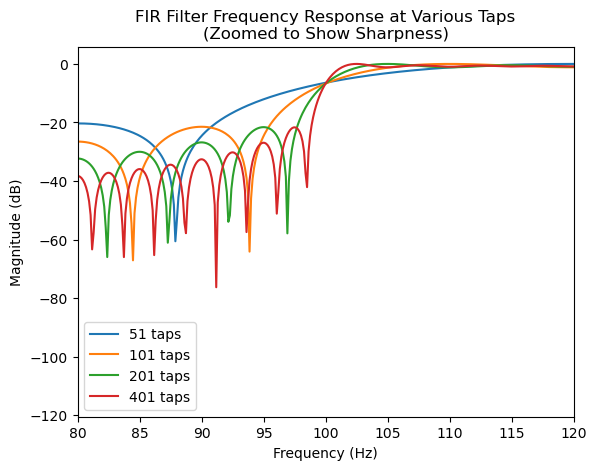

In [42]:
plt.plot(freqs, decibels1, label = "51 taps")
plt.plot(freqs, decibels2, label = "101 taps")
plt.plot(freqs, decibels3, label = "201 taps")
plt.plot(freqs, decibels4, label = "401 taps")
plt.title("FIR Filter Frequency Response at Various Taps\n(Zoomed to Show Sharpness)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.legend()
plt.xlim(80, 120)
plt.show()